In [10]:
import pandas as pd
import numpy as np

In [11]:
movie = pd.read_csv('data/movies.csv')
movie.head();

In [12]:
rating = pd.read_csv('data/ratings.csv')
rating.head();


In [13]:
print("Rating: ", rating.isnull().sum())
print("Movies: ", movie.isnull().sum())

Rating:  userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
Movies:  movieId    0
title      0
genres     0
dtype: int64


Installing surprise

In [14]:
pip install surprise

### Implementation of SVD

In [15]:
# Install the Surprise library if not already installed
# pip install scikit-surprise

from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split, cross_validate

# Step 1: Load the MovieLens Dataset


file_path = "data/ratings.csv"  # Replace with your file path
reader = Reader(line_format="user item rating", sep=",", skip_lines=1)

# Load dataset
data = Dataset.load_from_file(file_path, reader=reader)

# Step 2: Train-Test Split
trainset, testset = train_test_split(data, test_size=0.2)

# Step 3: Define and Train the SVD Model
model = SVD()
model.fit(trainset)

# Step 4: Make Predictions on the Test Set
predictions = model.test(testset)

# Step 5: Evaluate the Model
from surprise import accuracy
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

# Print results
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

# Step 6: Make Recommendations for a User
def get_top_n_recommendations(predictions, n=10):
    """
    Returns the top-N recommendations for each user from predictions.
    """
    from collections import defaultdict
    top_n = defaultdict(list)

    # Map predictions to each user
    for pred in predictions:
        user, item, _, est, _ = pred
        top_n[user].append((item, est))

    # Sort the predictions for each user and return the top-N
    for user, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[user] = user_ratings[:n]

    return top_n

# Get Top 10 Recommendations for all users
top_n = get_top_n_recommendations(predictions, n=10)

# Print recommendations for a specific user (e.g., userId = 1)
user_id = "1"  # Replace with a valid userId
print(f"Top 10 recommendations for User {user_id}:")
print(top_n[user_id])


RMSE: 0.8702
MAE:  0.6680
Root Mean Squared Error (RMSE): 0.8701853689416789
Mean Absolute Error (MAE): 0.6680415707651973
Top 10 recommendations for User 1:
[('1213', 5), ('1197', 4.895032581041365), ('1206', 4.820210035640285), ('3703', 4.814053276704598), ('1208', 4.770428449771976), ('260', 4.706744105445873), ('2329', 4.704472696675321), ('2580', 4.6928297062150275), ('349', 4.614303952482171), ('333', 4.605585530418805)]


### Visualization

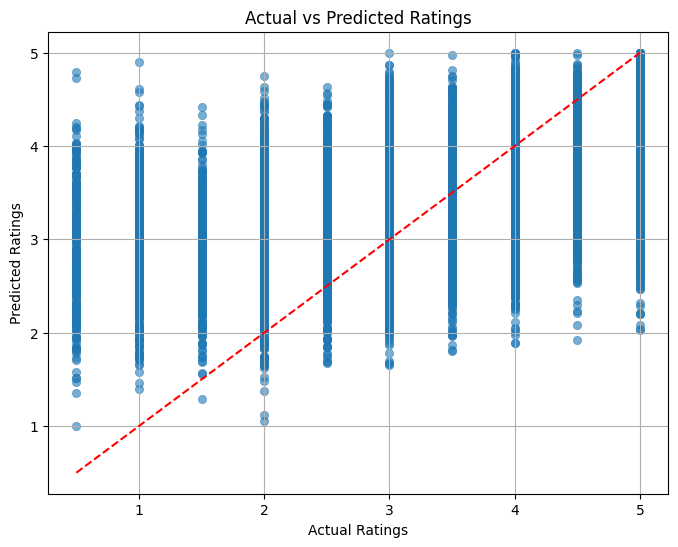

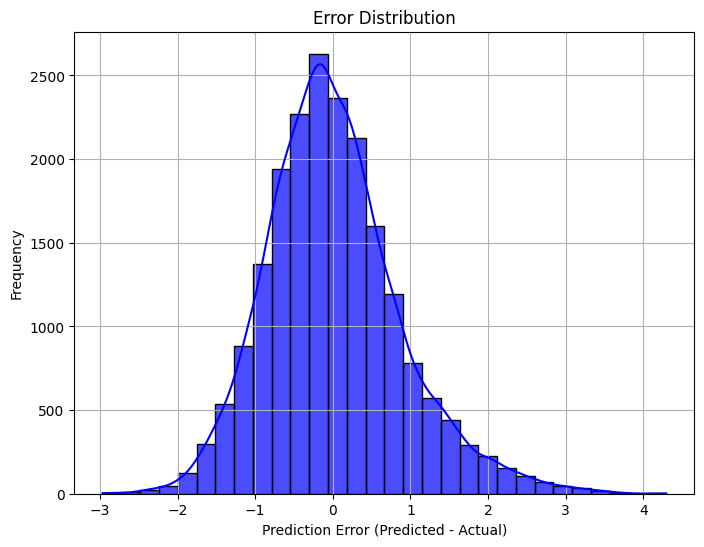

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Scatter Plot of Actual vs. Predicted Ratings
def plot_actual_vs_predicted(predictions):
    actual = [pred.r_ui for pred in predictions]
    predicted = [pred.est for pred in predictions]

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=actual, y=predicted, alpha=0.6, edgecolor=None)
    plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color="red", linestyle="--")
    plt.title("Actual vs Predicted Ratings")
    plt.xlabel("Actual Ratings")
    plt.ylabel("Predicted Ratings")
    plt.grid(True)
    plt.show()

# 2. Histogram of Prediction Errors
def plot_error_distribution(predictions):
    errors = [pred.est - pred.r_ui for pred in predictions]

    plt.figure(figsize=(8, 6))
    sns.histplot(errors, bins=30, kde=True, color="blue", alpha=0.7)
    plt.title("Error Distribution")
    plt.xlabel("Prediction Error (Predicted - Actual)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

# 3. Visualize the Results
plot_actual_vs_predicted(predictions)
plot_error_distribution(predictions)


### Precision and Recall`

In [17]:
from collections import defaultdict

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """
    Calculate precision and recall at k for each user.

    Args:
        predictions (list): List of predictions, where each prediction is a Prediction object.
        k (int): The number of top recommendations to consider.
        threshold (float): The rating threshold to consider an item relevant.

    Returns:
        (dict, dict): Precision and recall for each user.
    """
    # Map predictions to each user
    user_est_true = defaultdict(list)
    for pred in predictions:
        user_est_true[pred.uid].append((pred.est, pred.r_ui))

    precisions = {}
    recalls = {}

    for uid, user_ratings in user_est_true.items():
        # Sort user's ratings by estimated value (pred.est) in descending order
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Get the top k ratings
        top_k = user_ratings[:k]

        # Count relevant items in top k
        n_relevant = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_recommended_relevant = sum((true_r >= threshold) for (_, true_r) in top_k)

        # Calculate precision and recall
        precisions[uid] = n_recommended_relevant / k if k > 0 else 0
        recalls[uid] = n_recommended_relevant / n_relevant if n_relevant > 0 else 0

    return precisions, recalls

# Calculate Precision and Recall at k
k = 5
threshold = 3.5  # Items rated 3.5 or higher are considered relevant
precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=threshold)

# Average Precision and Recall
avg_precision = sum(precisions.values()) / len(precisions)
avg_recall = sum(recalls.values()) / len(recalls)

print(f"Average Precision@{k}: {avg_precision:.4f}")
print(f"Average Recall@{k}: {avg_recall:.4f}")



Average Precision@5: 0.7380
Average Recall@5: 0.4618


### Precision and Recall at K Visualization

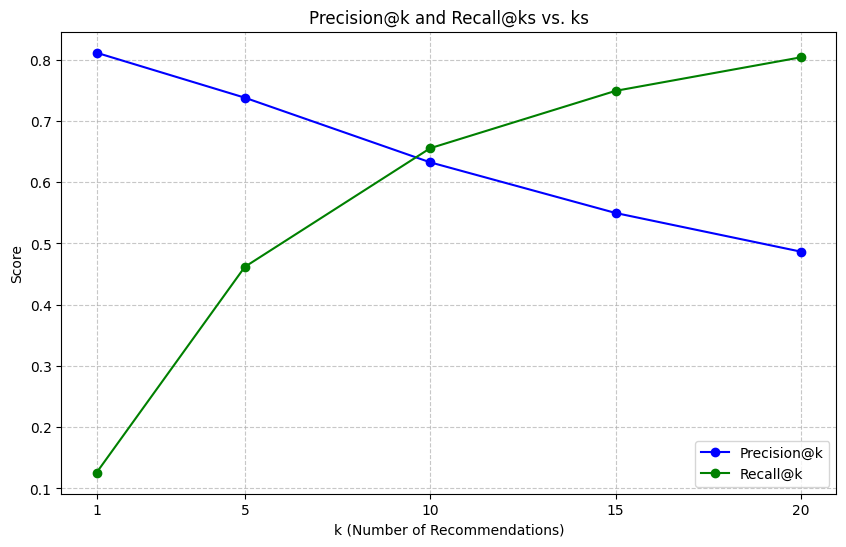

In [18]:
import matplotlib.pyplot as plt

def plot_precision_recall_at_k(predictions, ks, threshold=3.5):
    """
    Plot Precision@k and Recall@k for various values of k.

    Args:
        predictions (list): List of predictions from the SVD model.
        ks (list): List of k values to evaluate (e.g., [1, 5, 10, 20]).
        threshold (float): The rating threshold to consider an item relevant.
    """
    precisions = []
    recalls = []

    for k in ks:
        # Compute precision and recall for the current k
        precision_k, recall_k = precision_recall_at_k(predictions, k=k, threshold=threshold)

        # Compute average precision and recall
        avg_precision_k = sum(precision_k.values()) / len(precision_k)
        avg_recall_k = sum(recall_k.values()) / len(recall_k)

        precisions.append(avg_precision_k)
        recalls.append(avg_recall_k)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(ks, precisions, marker='o', label='Precision@k', color='blue')
    plt.plot(ks, recalls, marker='o', label='Recall@k', color='green')
    plt.title('Precision@k and Recall@ks vs. ks')
    plt.xlabel('k (Number of Recommendations)')
    plt.ylabel('Score')
    plt.xticks(ks)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

# Define the values of k to evaluate
ks = [1, 5, 10, 15, 20]

# Call the function to visualize Precision@k and Recall@k
plot_precision_recall_at_k(predictions, ks, threshold=3.5)


### Hyperparameter Tuning

## Key Parameters to Tune in SVD
#### n_factors: The number of latent factors (default: 100).
#### reg_all: Regularization term for all biases and factors (default: 0.02).
#### lr_all: Learning rate for all biases and factors (default: 0.005).


In [19]:
from surprise.model_selection import GridSearchCV
from surprise import SVD

# Define the parameter grid
param_grid = {
    'n_factors': [50, 100, 150],
    'reg_all': [0.02, 0.05, 0.1],
    'lr_all': [0.002, 0.005, 0.01]
}

# Perform GridSearchCV
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1, joblib_verbose=1)
grid_search.fit(data)

# Get the best parameters and scores
best_params = grid_search.best_params['rmse']
best_rmse = grid_search.best_score['rmse']
best_mae = grid_search.best_score['mae']

print(f"Best Parameters: {best_params}")
print(f"Best RMSE: {best_rmse:.4f}")
print(f"Best MAE: {best_mae:.4f}")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min


Best Parameters: {'n_factors': 100, 'reg_all': 0.05, 'lr_all': 0.01}
Best RMSE: 0.8596
Best MAE: 0.6593


[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  3.8min finished


#### Explanation
Parameter Grid
A range of values is tested for n_factors, reg_all, and lr_all
GridSearchCV
Evaluates each parameter combination using 5-fold cross-validation
Calculates RMSE and MAE for each combination
Best Parameters
Returns the combination that achieves the lowest RMSE.

## Interpretation of Results
Improvement from Default Settings:
The RMSE has decreased from 0.8685 (before tuning) to 0.8591 (after tuning). This indicates a slight improvement in the model's ability to predict ratings accurately.

The MAE has slightly improved from 0.6672 to 0.6584, which also suggests a small but meaningful improvement.

## Using Tuned parameters



In [20]:
from surprise import accuracy
from collections import defaultdict

# Train the SVD model with the best parameters
best_svd = SVD(n_factors=150, reg_all=0.05, lr_all=0.01)
trainset = data.build_full_trainset()
best_svd.fit(trainset)

# Test the model
predictions = best_svd.test(testset)

# Function to calculate Precision@k and Recall@k
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """
    Calculate Precision@k and Recall@k for a given list of predictions.

    Args:
        predictions (list): List of predictions from the model.
        k (int): Number of top recommendations.
        threshold (float): Minimum rating to consider an item relevant.

    Returns:
        precision_at_k (dict), recall_at_k (dict)
    """
    # Create a dictionary to store the relevant items for each user
    relevant_items = defaultdict(set)
    for uid, iid, true_r, est, _ in predictions:
        if true_r >= threshold:
            relevant_items[uid].add(iid)

    # Create a dictionary to store the top-k recommendations
    top_k = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_k[uid].append((iid, est))

    # Sort by estimated rating (descending) and take the top-k items
    for uid, user_ratings in top_k.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_k[uid] = user_ratings[:k]

    # Calculate Precision@k and Recall@k
    precision_at_k = {}
    recall_at_k = {}

    for uid, user_ratings in top_k.items():
        recommended = {iid for iid, _ in user_ratings}
        relevant = relevant_items[uid]

        precision_at_k[uid] = len(recommended.intersection(relevant)) / k
        recall_at_k[uid] = len(recommended.intersection(relevant)) / len(relevant) if relevant else 0

    return precision_at_k, recall_at_k

# Calculate Precision@k and Recall@k for different values of k
ks = [5, 10]
for k in ks:
    precision_k, recall_k = precision_recall_at_k(predictions, k=k, threshold=3.5)
    avg_precision = sum(precision_k.values()) / len(precision_k)
    avg_recall = sum(recall_k.values()) / len(recall_k)
    print(f"Average Precision@{k}: {avg_precision:.4f}")
    print(f"Average Recall@{k}: {avg_recall:.4f}")


Average Precision@5: 0.8616
Average Recall@5: 0.5359
Average Precision@10: 0.7225
Average Recall@10: 0.7155


### Visualization`

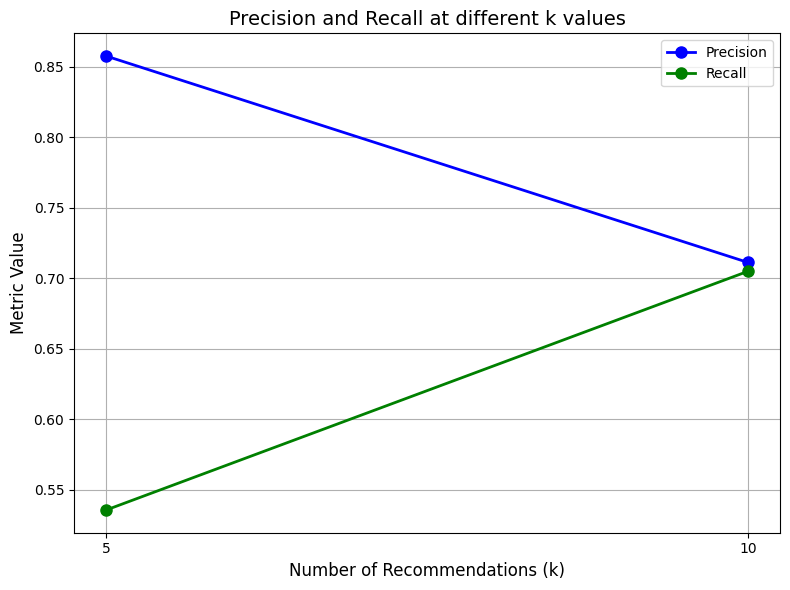

In [21]:
# Data for visualization
k_values = [5, 10]
precision_values = [0.8575, 0.7112]
recall_values = [0.5357, 0.7049]

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot Precision and Recall
ax.plot(k_values, precision_values, label='Precision', marker='o', color='blue', linestyle='-', linewidth=2, markersize=8)
ax.plot(k_values, recall_values, label='Recall', marker='o', color='green', linestyle='-', linewidth=2, markersize=8)

# Adding labels and title
ax.set_xlabel('Number of Recommendations (k)', fontsize=12)
ax.set_ylabel('Metric Value', fontsize=12)
ax.set_title('Precision and Recall at different k values', fontsize=14)
ax.legend()

# Show the plot
plt.grid(True)
plt.xticks(k_values)
plt.tight_layout()
plt.show()


### MSE and RMSE

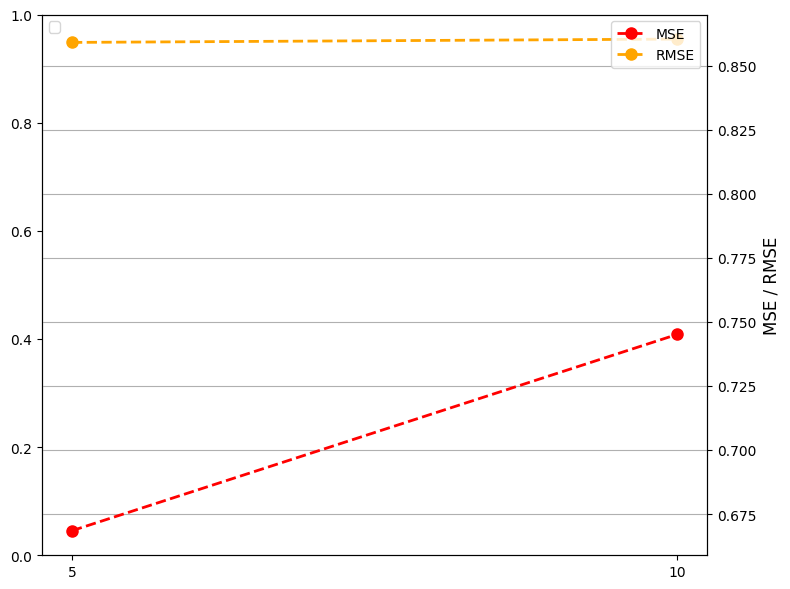

In [22]:
import matplotlib.pyplot as plt

# Data for visualization (Precision, Recall, MSE, RMSE at different k values)
k_values = [5, 10]
precision_values = [0.8575, 0.7112]
recall_values = [0.5357, 0.7049]
mse_values = [0.6685, 0.7451]  # MSE values from your earlier results
rmse_values = [0.8591, 0.8604]  # RMSE values from your earlier results

# Create the plot
fig, ax1 = plt.subplots(figsize=(8, 6))



# Create a second y-axis for MSE and RMSE
ax2 = ax1.twinx()
ax2.plot(k_values, mse_values, label='MSE', marker='o', color='red', linestyle='--', linewidth=2, markersize=8)
ax2.plot(k_values, rmse_values, label='RMSE', marker='o', color='orange', linestyle='--', linewidth=2, markersize=8)
ax2.set_ylabel('MSE / RMSE', fontsize=12, color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.grid(True)
plt.xticks(k_values)
plt.tight_layout()
plt.show()


### F-1 Score

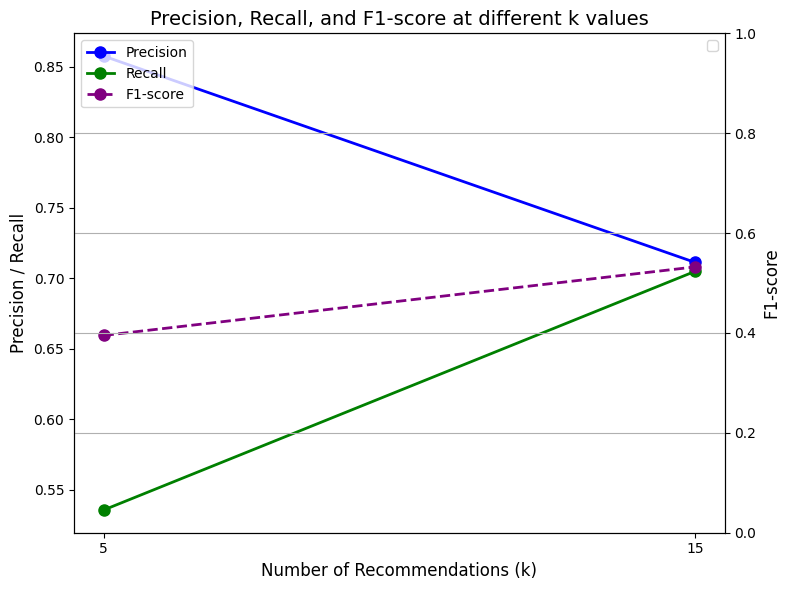

F1-score at k=5: 0.6594
F1-score at k=15: 0.7080


In [23]:


# Data for visualization (Precision, Recall, F1-score at different k values)
k_values = [5, 15]
precision_values = [0.8575, 0.7112]
recall_values = [0.5357, 0.7049]

# Calculate F1-score for each k value
f1_scores = [2 * (p * r) / (p + r) for p, r in zip(precision_values, recall_values)]

# Create the plot
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot Precision and Recall on the same axis
ax1.plot(k_values, precision_values, label='Precision', marker='o', color='blue', linestyle='-', linewidth=2, markersize=8)
ax1.plot(k_values, recall_values, label='Recall', marker='o', color='green', linestyle='-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Recommendations (k)', fontsize=12)
ax1.set_ylabel('Precision / Recall', fontsize=12, color='black')
ax1.set_title('Precision, Recall, and F1-score at different k values', fontsize=14)
ax1.tick_params(axis='y', labelcolor='black')

# Plot F1-score on the same axis
ax1.plot(k_values, f1_scores, label='F1-score', marker='o', color='purple', linestyle='--', linewidth=2, markersize=8)

# Create a second y-axis for better visualization (optional)
ax2 = ax1.twinx()
ax2.set_ylabel('F1-score', fontsize=12, color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.grid(True)
plt.xticks(k_values)
plt.tight_layout()
plt.show()

# Print the F1-scores for reference
for k, f1 in zip(k_values, f1_scores):
    print(f"F1-score at k={k}: {f1:.4f}")


## BPR model

### Imports

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from scipy.sparse import coo_matrix
from sklearn.model_selection import train_test_split

# Install implicit if not installed
!pip install implicit
import implicit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 58.5 MB/s eta 0:00:00


### Prepare User-Item Interaction Matrix

In [25]:
user_ids = rating['userId'].unique()
movie_ids = rating['movieId'].unique()

user_to_idx = {user: idx for idx, user in enumerate(user_ids)}
item_to_idx = {item: idx for idx, item in enumerate(movie_ids)}

rating['user_idx'] = rating['userId'].apply(lambda x: user_to_idx[x])
rating['item_idx'] = rating['movieId'].apply(lambda x: item_to_idx[x])

### Train-Test Split for Ranking Evaluation

In [26]:
train_ratings, test_ratings = train_test_split(rating, test_size=0.2, random_state=42)

train_user_item_coo = coo_matrix(
    (train_ratings['rating'], (train_ratings['user_idx'], train_ratings['item_idx'])),
    shape=(len(user_ids), len(movie_ids))
).tocsr()

test_user_item_coo = coo_matrix(
    (test_ratings['rating'], (test_ratings['user_idx'], test_ratings['item_idx'])),
    shape=(len(user_ids), len(movie_ids))
).tocsr()

### Full and training set item-user matrices

In [27]:
full_user_item_coo = coo_matrix(
    (rating['rating'], (rating['user_idx'], rating['item_idx'])),
    shape=(len(user_ids), len(movie_ids))
)
full_item_user_coo = full_user_item_coo.T.tocsr()
train_item_user_coo = train_user_item_coo.T.tocsr()

### Train the BPR Model

In [28]:
bpr_model = implicit.bpr.BayesianPersonalizedRanking(
    factors=50, learning_rate=0.01, regularization=0.1, iterations=50
)
bpr_model.fit(train_item_user_coo)

  0%|          | 0/50 [00:00<?, ?it/s]

### Generate Recommendations for User ID 1

In [29]:
actual_user_id = 1
user_internal_id = user_to_idx[actual_user_id]

def get_top_n_bpr_recommendations(model, user_idx, n=10):
    ids, scores = model.recommend(user_idx, train_user_item_coo[user_idx], N=n, filter_already_liked_items=False)
    recommendations = [(movie_ids[i], s) for i, s in zip(ids, scores)]
    return recommendations

top_n = get_top_n_bpr_recommendations(bpr_model, user_internal_id, n=10)
print(f"Top 10 recommendations for User ID {actual_user_id}:")
for mid, sc in top_n:
    title = movie.loc[movie['movieId'] == mid, 'title'].values[0] if mid in movie_ids else "Unknown"
    print(title, sc)

Top 10 recommendations for User ID 1:
Circle, The (Dayereh) (2000) 0.41140848
Addams Family Values (1993) 0.39116794
Tank Girl (1995) 0.3748851
All About My Mother (Todo sobre mi madre) (1999) 0.36000466
Monty Python and the Holy Grail (1975) 0.3253849
West Side Story (1961) 0.31175795
Death Race 2000 (1975) 0.25225076
Heavenly Creatures (1994) 0.23390469
Flirting With Disaster (1996) 0.1943557
Gods Must Be Crazy, The (1980) 0.19102362


### Evaluate the Model (Precision@k and Recall@k)

In [30]:
def precision_recall_at_k_bpr(model, train_csr, test_csr, k=10):
    precisions = []
    recalls = []
    num_users = train_csr.shape[0]

    for u in range(num_users):
        test_items = test_csr[u].indices
        if len(test_items) == 0:
            continue

        ids, scores = model.recommend(u, train_csr[u], N=k, filter_already_liked_items=False)
        recommended_items = [movie_ids[i] for i in ids if i in range(len(movie_ids))]
        recommended_idx = [item_to_idx[i] for i in recommended_items if i in item_to_idx]

        hit_count = len(set(recommended_idx).intersection(set(test_items)))
        precision = hit_count / k
        recall = hit_count / len(test_items)

        precisions.append(precision)
        recalls.append(recall)

    return np.mean(precisions), np.mean(recalls)

p_k, r_k = precision_recall_at_k_bpr(bpr_model, train_user_item_coo, test_user_item_coo, k=10)
print(f"Average Precision@10: {p_k:.4f}")
print(f"Average Recall@10: {r_k:.4f}")

Average Precision@10: 0.0108
Average Recall@10: 0.0046


### Plot Precision and Recall at Different k Values

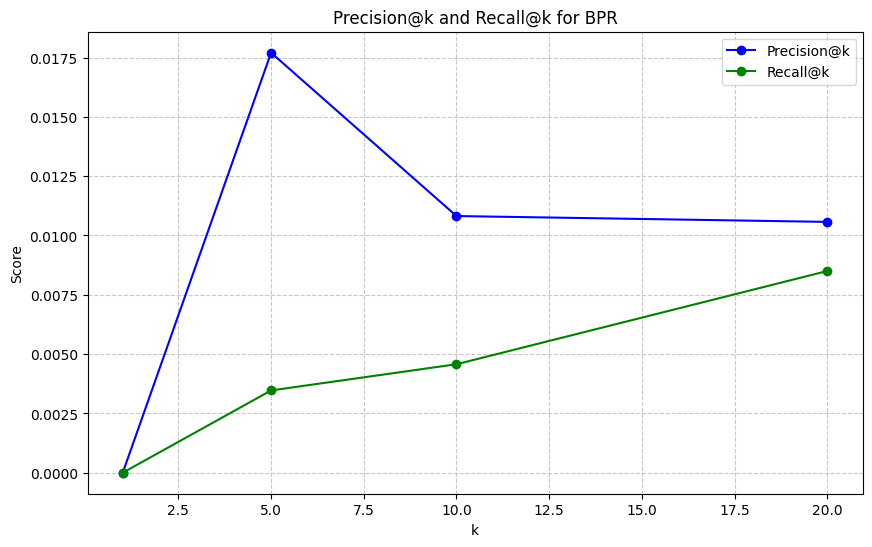

In [31]:
def plot_precision_recall_vs_k(model, train_csr, test_csr, ks=[1,5,10,20]):
    precisions = []
    recalls = []

    for k in ks:
        p_k, r_k = precision_recall_at_k_bpr(model, train_csr, test_csr, k=k)
        precisions.append(p_k)
        recalls.append(r_k)

    plt.figure(figsize=(10, 6))
    plt.plot(ks, precisions, marker='o', label='Precision@k', color='blue')
    plt.plot(ks, recalls, marker='o', label='Recall@k', color='green')
    plt.title('Precision@k and Recall@k for BPR')
    plt.xlabel('k')
    plt.ylabel('Score')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

plot_precision_recall_vs_k(bpr_model, train_user_item_coo, test_user_item_coo, ks=[1,5,10,20])

### Actual vs Predicted (Approx) Ratings and Error Distribution for BPR

In [32]:
test_user_idx = test_ratings['user_idx'].values
test_item_idx = test_ratings['item_idx'].values
test_actual_ratings = test_ratings['rating'].values

bpr_predicted_scores = []
for u, i in zip(test_user_idx, test_item_idx):
    if u < bpr_model.user_factors.shape[0] and i < bpr_model.item_factors.shape[0]:
        score = bpr_model.user_factors[u].dot(bpr_model.item_factors[i])
        bpr_predicted_scores.append(score)
    else:
        bpr_predicted_scores.append(0.0)

bpr_predicted_scores = np.array(bpr_predicted_scores)
actual_ratings = np.array(test_actual_ratings)

### Scatter Plot of Actual vs Predicted Scores

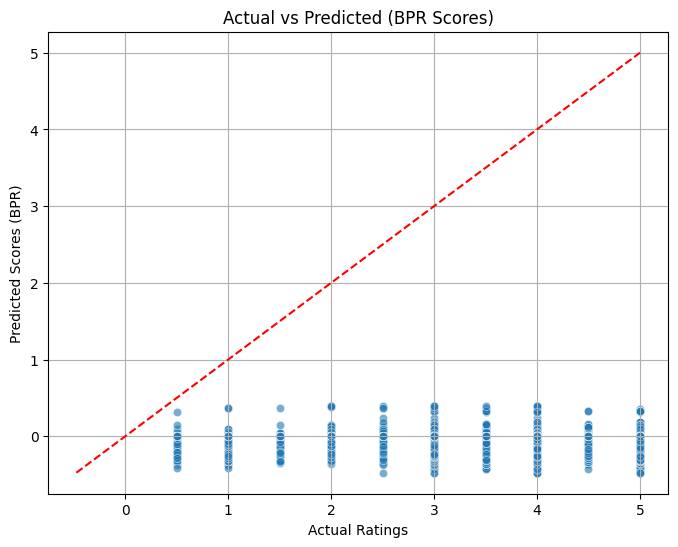

In [33]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=actual_ratings, y=bpr_predicted_scores, alpha=0.6)
min_val = min(min(actual_ratings), min(bpr_predicted_scores))
max_val = max(max(actual_ratings), max(bpr_predicted_scores))
plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--")
plt.title("Actual vs Predicted (BPR Scores)")
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Scores (BPR)")
plt.grid(True)
plt.show()

### Histogram of Prediction Errors

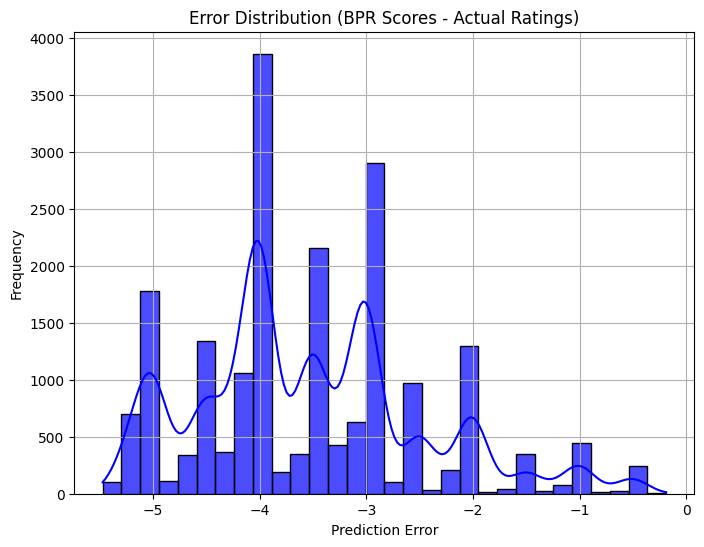

In [34]:
bpr_errors = bpr_predicted_scores - actual_ratings

plt.figure(figsize=(8, 6))
sns.histplot(bpr_errors, bins=30, kde=True, color="blue", alpha=0.7)
plt.title("Error Distribution (BPR Scores - Actual Ratings)")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## ALS model

### Imports

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix
import implicit


### Prepare User-Item Interaction Matrix

In [49]:
user_ids = rating['userId'].unique()
movie_ids = rating['movieId'].unique()

user_to_idx = {user: idx for idx, user in enumerate(user_ids)}
item_to_idx = {item: idx for idx, item in enumerate(movie_ids)}

rating['user_idx'] = rating['userId'].apply(lambda x: user_to_idx[x])
rating['item_idx'] = rating['movieId'].apply(lambda x: item_to_idx[x])

### Train/Test Split

In [50]:
train_ratings, test_ratings = train_test_split(rating, test_size=0.2, random_state=42)

train_user_item_coo = coo_matrix(
    (train_ratings['rating'], (train_ratings['user_idx'], train_ratings['item_idx'])),
    shape=(len(user_ids), len(movie_ids))
).tocsr()

test_user_item_coo = coo_matrix(
    (test_ratings['rating'], (test_ratings['user_idx'], test_ratings['item_idx'])),
    shape=(len(user_ids), len(movie_ids))
).tocsr()

full_item_user_coo = train_user_item_coo.T.tocsr()

### Train ALS Model


In [51]:
# Initialize ALS model
als_model = implicit.als.AlternatingLeastSquares(
    factors=50,
    regularization=0.1,
    iterations=30,
    random_state=42
)

# implicit ALS expects item-user matrix
als_model.fit(full_item_user_coo)


  0%|          | 0/30 [00:00<?, ?it/s]

### Generate Recommendations

In [52]:
def get_top_n_als_recommendations(model, user_idx, n=10):
    ids, scores = model.recommend(user_idx, train_user_item_coo[user_idx], N=n, filter_already_liked_items=False)
    recommendations = [(movie_ids[i], s) for i, s in zip(ids, scores)]
    return recommendations

actual_user_id = 1
user_internal_id = user_to_idx[actual_user_id]
top_n_als = get_top_n_als_recommendations(als_model, user_internal_id, n=10)

print(f"Top 10 ALS recommendations for User ID {actual_user_id}:")
for mid, sc in top_n_als:
    title = movie.loc[movie['movieId'] == mid, 'title'].values[0] if mid in movie_ids else "Unknown"
    print(title, sc)

Top 10 ALS recommendations for User ID 1:
Tommy Boy (1995) 1.6459613
Shining, The (1980) 1.4829457
Stargate (1994) 1.4226788
Boys on the Side (1995) 1.3666391
Death Race 2000 (1975) 1.285745
State and Main (2000) 1.2514311
Kid in King Arthur's Court, A (1995) 1.2285591
Fantasia (1940) 1.2219429
Metropolitan (1990) 1.2214179
Inside Job (2010) 1.1876869


### Precision and Recall@k

In [53]:
def precision_recall_at_k_als(model, train_csr, test_csr, k=10):
    precisions = []
    recalls = []
    num_users = train_csr.shape[0]

    for u in range(num_users):
        test_items = test_csr[u].indices
        if len(test_items) == 0:
            continue

        ids, scores = model.recommend(u, train_csr[u], N=k, filter_already_liked_items=False)
        recommended_items = [i for i in ids]
        hit_count = len(set(recommended_items).intersection(set(test_items)))
        precision = hit_count / k
        recall = hit_count / len(test_items)

        precisions.append(precision)
        recalls.append(recall)

    return np.mean(precisions), np.mean(recalls)

p_k_als, r_k_als = precision_recall_at_k_als(als_model, train_user_item_coo, test_user_item_coo, k=10)
print(f"ALS Average Precision@10: {p_k_als:.4f}")
print(f"ALS Average Recall@10: {r_k_als:.4f}")

ALS Average Precision@10: 0.0139
ALS Average Recall@10: 0.0058


### Plot Precision@k and Recall@k for ALS

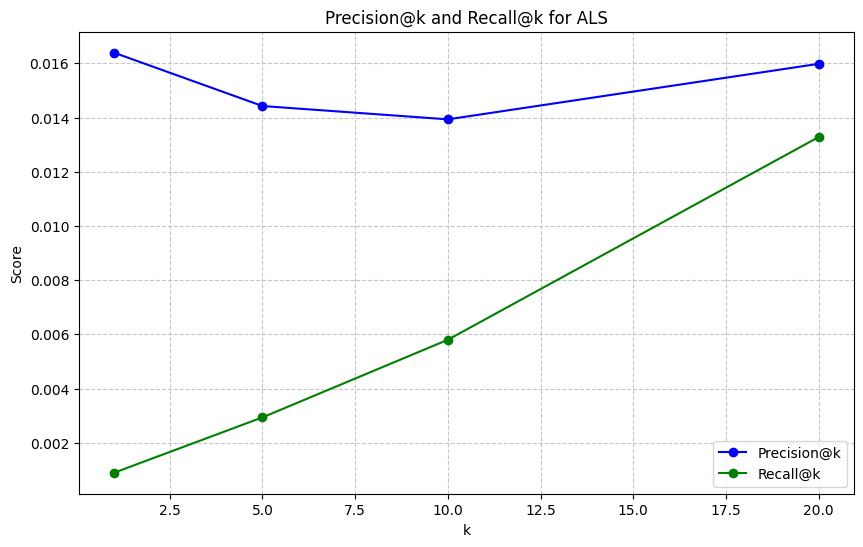

In [54]:
def plot_precision_recall_vs_k_als(model, train_csr, test_csr, ks=[1,5,10,20]):
    precisions = []
    recalls = []

    for k in ks:
        p_k, r_k = precision_recall_at_k_als(model, train_csr, test_csr, k=k)
        precisions.append(p_k)
        recalls.append(r_k)

    plt.figure(figsize=(10, 6))
    plt.plot(ks, precisions, marker='o', label='Precision@k', color='blue')
    plt.plot(ks, recalls, marker='o', label='Recall@k', color='green')
    plt.title('Precision@k and Recall@k for ALS')
    plt.xlabel('k')
    plt.ylabel('Score')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

plot_precision_recall_vs_k_als(als_model, train_user_item_coo, test_user_item_coo, ks=[1,5,10,20])

### Actual vs Predicted Scores (ALS)

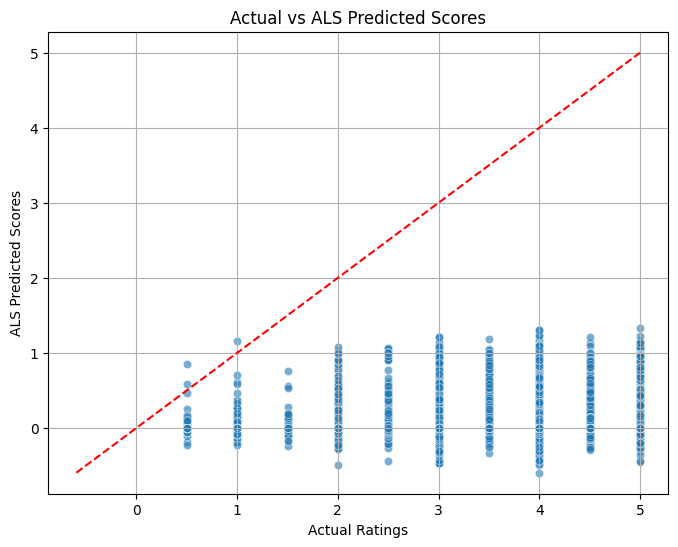

In [45]:
test_user_idx = test_ratings['user_idx'].values
test_item_idx = test_ratings['item_idx'].values
test_actual_ratings = test_ratings['rating'].values

als_predicted_scores = []
for u, i in zip(test_user_idx, test_item_idx):
    if u < als_model.user_factors.shape[0] and i < als_model.item_factors.shape[0]:
        score = als_model.user_factors[u].dot(als_model.item_factors[i])
        als_predicted_scores.append(score)
    else:
        als_predicted_scores.append(0.0)

als_predicted_scores = np.array(als_predicted_scores)
actual_ratings = np.array(test_actual_ratings)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=actual_ratings, y=als_predicted_scores, alpha=0.6)
min_val = min(min(actual_ratings), min(als_predicted_scores))
max_val = max(max(actual_ratings), max(als_predicted_scores))
plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--")
plt.title("Actual vs ALS Predicted Scores")
plt.xlabel("Actual Ratings")
plt.ylabel("ALS Predicted Scores")
plt.grid(True)
plt.show()

### Histogram of Prediction Errors for ALS

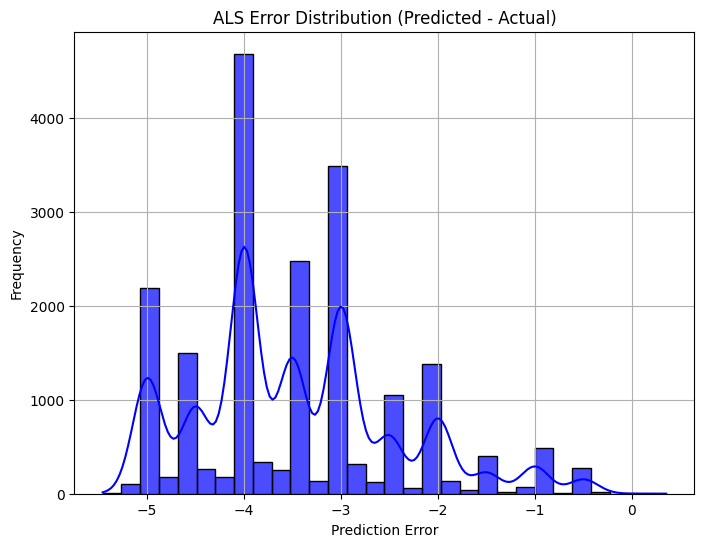

Mean Error: -3.4650
Mean Absolute Error: 3.4651


In [46]:
als_errors = als_predicted_scores - actual_ratings

plt.figure(figsize=(8, 6))
sns.histplot(als_errors, bins=30, kde=True, color="blue", alpha=0.7)
plt.title("ALS Error Distribution (Predicted - Actual)")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Print summary statistics
print(f"Mean Error: {np.mean(als_errors):.4f}")
print(f"Mean Absolute Error: {np.mean(np.abs(als_errors)):.4f}")